In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial
from scipy import signal

In [18]:
sampling = 0.1

plt.rcParams['figure.figsize'] = [11, 13]
plt.rcParams['figure.dpi'] = 100

x = np.arange(-4, 4, sampling)

In [19]:
def FFT(data):
    return fft.fft(data, len(data))
def iFFT(data):
    return fft.ifft(data)

#get axis to plot FT on
def getFreqAxis(x):
    return np.fft.fftfreq(len(x), d=sampling)
def flipAtOrigin(data):
    tmp = np.split(data, 2)
    return np.concatenate([tmp[1], tmp[0]])

def rect(w, x):
    return 1 if np.abs(x)<=w else 0

In [20]:
def plotFreq(axs, data, label = None, color = 'red'):
    freqAxis = np.fft.fftfreq(len(x), d=sampling)
    freqAxis = freqAxis[:len(freqAxis)//2]
    axs.plot(freqAxis, np.abs(np.split(data, 2)[0]), label = label, color = color)
    axs.grid()
    axs.legend()
    pid += 1
    
    

In [21]:
def lowPassFilterPerfect(w, x):
    return 1.0 if np.abs(x) < w else 0

In [71]:
#x - fft of original
#y - resampled fft
def resample(x, y):
    N = len(x)
    M = len(y)
    for i in range(len(y)):
        if 0<=i<=N/2:
            y[i] = x[i]
        if N/2 + M - N < i < M:
            y[i] = x[i-M+N]
def sampleRateConv(data, newLen):
    fig, axs = plt.subplots(4)
    fftData = FFT(data)
    pid = 0
    f_fft = flipAtOrigin(fftData)
    #axs[pid].plot(np.abs(fftData),  label = "original fft")
    #axs[pid].legend()
    #axs[pid].grid()
    plotFreq(axs[pid], fftData, "original fft")
    pid += 1
    
    scaledFt = np.zeros(newLen, dtype = np.complex128)
    resample(fftData, scaledFt)
    axs[pid].plot(np.abs(scaledFt))
    pid += 1
    
    func = fft.ifft(scaledFt)
    axs[pid].plot(np.real(func))
    
    pid += 1
    axs[pid].plot(np.real(data))

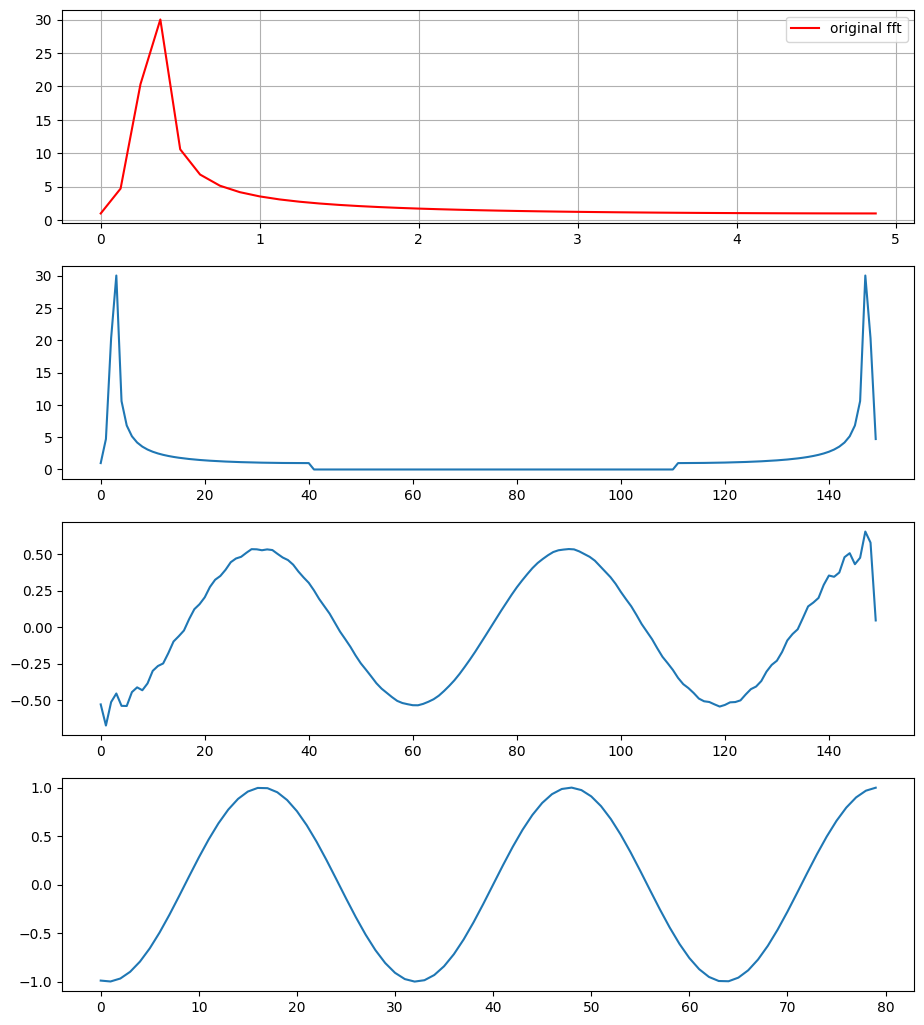

In [72]:
sampleRateConv(np.vectorize(np.sin)(2*x), 150)